<h1><center>How to export 🤗 Transformers Models to ONNX ?<h1><center>

[ONNX](http://onnx.ai/) is open format graph representation for machine learning models. It allows to save your neural network's computation graph in a framework agnostic way, which might be particulary helpful when deploying deep learning models.

Indeed, businesses might have other requirements _(languages, hardware, ...)_ for which the training framework might not be the best suited in inference scenarios. In that context, having a representation of the actual computation graph that can be shared accross various business units and logics across an organization might be a desirable component.

Along with the serialization format, ONNX also provides a runtime library which allows efficient and hardware specific execution of the ONNX graph. This is done through the [onnxruntime](https://microsoft.github.io/onnxruntime/) project and already includes collaborations with many hardware vendors to seamlessly deploy models on various platforms.

Through this notebook we'll walk you through the process to convert a PyTorch or TensorFlow transformers model to the [ONNX](http://onnx.ai/) and leverage [onnxruntime](https://microsoft.github.io/onnxruntime/) to run inference tasks on models from  🤗 __transformers__

## Exporting 🤗 transformers model to ONNX

---

Exporting models _(either PyTorch or TensorFlow)_ is easily achieved through the conversion tool provided as part of 🤗 __transformers__ repository. 

Under the hood the process is sensibly the following: 

1. Allocate the model from transformers (PyTorch or TensorFlow)
2. Forward dummy inputs through the model this way ONNX can record the set of operations executed
3. Optionally define dynamic axes on inputs and output tensors
4. Save the graph along with the network parameters

In [ ]:
!pip install git+https://github.com/huggingface/transformers@onnx-export
!pip install pydot graphviz

In [ ]:
from transformers.convert_graph_to_onnx import convert

# Handles all the above steps for you
convert(framework="pt", model="bert-base-cased", output="onnx/bert-base-cased.onnx")

Here is the ONNX generated computation graph visualized. You can see a very fine grained computational graph. This is what ONNX call the "raw" graph which
is expressed only through ONNX opcode, available into all providers.



## How to leverage runtime for inference over an ONNX graph

---

As mentionned in the introduction, ONNX is serialization format and many side projects can load the saved graph and run the actual computation on it. Here, we'll focus on the official [onnxruntime](https://microsoft.github.io/onnxruntime/). The runtime is implemented as in C++ for performance reasons and provides API/Bindings for C++, C, C#, Java and Python.

Next, we will use the Python API to highlight how to load a serialized ONNX graph and run inference workload on various backends.

**onnxruntime** is available through pip:

- onnxruntime: ONNX + MLAS (Microsoft Linear Algebra Subprograms)
- onnxruntime-gpu: ONNX + MLAS + CUDA


In [ ]:
!pip install transformers onnxruntime-gpu onnx

In [17]:
from os import environ
from onnxruntime import GraphOptimizationLevel, ExecutionMode, InferenceSession, SessionOptions, get_all_providers
from transformers import BertTokenizerFast
from psutil import cpu_count

# Constants from the performance optimization available in onnxruntime
environ["OMP_NUM_THREADS"] = str(cpu_count(logical=True))
environ["OMP_WAIT_POLICY"] = 'ACTIVE'

## Preparing for an Inference Session

---

Inference is done using a specific backend definition which turns on hardware specific optimizations of the graph. 

Optimizations are basically of three kinds: 

- **Constant Folding**: Convert static variables to constants in the graph 
- **Deadcode Elimination**: Remove nodes never accessed in the graph
- **Operator Fusing**: Merge multiple instruction into one (Linear -> ReLU can be fused to be LinearReLU)

All of this is done through ONNX by settings specific SessionOptions:

In [23]:
def create_model_for_provider(model_path: str, provider: str) -> InferenceSession: 
  
  assert provider in get_all_providers(), f"provider {provider} not found, {get_all_providers()}"

  # Few properties than might have an impact on performances (provided by MS)
  options = SessionOptions()
  options.intra_op_num_threads = 1
  options.execution_mode = ExecutionMode.ORT_SEQUENTIAL

  # This line tells CPU Backend to store the optimized graph for this backend
  options.optimized_model_filepath = f"onnx/bert-base-cased-{provider.split('Execution')[0]}-optimized.onnx"

  # Load the model as a graph and prepare the CPU backend 
  return InferenceSession(model_path, options, providers=[provider])

## Forwarding through our optimized ONNX model running on CPU

---

When the model is loaded for inference over a specific provider, for instance **CPUExecutionProvider** as above, an optimized graph can be saved. This graph will feature various optimizations, and you might be able to see some **higher-level** operations in the graph such as:
- EmbedLayerNormalization
- Attention
- FastGeLU

These operations are gathering multiple operations into one bigger (fusing).

In [24]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
cpu_model = create_model_for_provider("onnx/bert-base-cased.onnx", "CPUExecutionProvider")

# Inputs are provided through numpy array
model_inputs = tokenizer.encode_plus("My name is Bert")
inputs_onnx = {k: v.cpu().detach().numpy() for k, v in model_inputs.items()}

# Run the model (None = get all the outputs)
sequence, pooled = cpu_model.run(None, inputs_onnx)

# Print information about outputs

print(f"Sequence output: {sequence.shape}, Pooled output: {pooled.shape}")

RuntimeException: [ONNXRuntimeError] : 6 : RUNTIME_EXCEPTION : Exception during initialization: D:\Workspace\Python\onnxruntime\onnxruntime\core\optimizer\optimizer_execution_frame.cc:61 onnxruntime::OptimizerExecutionFrame::Info::Info [ONNXRuntimeError] : 1 : FAIL : GetFileSizeEx encoder.layer.11.output.dense.weight fail, errcode = 6


## Benchmarking different CPU & GPU providers

_**Disclamer: results may vary from the actual hardware used to run the model**_

In [0]:
from os.path import getsize
from torch.cuda import get_device_name
from contextlib import contextmanager
from dataclasses import dataclass
from time import time
from tqdm import trange

@contextmanager
def track_infer_time(buffer: [int]):
    start = time()
    yield
    end = time()

    buffer.append(end - start)


@dataclass
class OnnxInferenceResult:
  model_size: int
  model_inference_time: [int]  
  optimized_model_path: str


# All the providers we'll be using in the test
results = {}
providers = [
  "CUDAExecutionProvider",
  "CPUExecutionProvider",            
  "TensorrtExecutionProvider",
  "DnnlExecutionProvider",          
]

print(f"Doing GPU inference on {get_device_name(0)}")

# Iterate over all the providers
for provider in providers:

  # Create the model with the specified provider
  model = create_model_for_provider(provider)

  # Keep track of the inference time
  time_buffer = []

  # Warm up the model
  for _ in trange(10, desc="Warming up"):
    model.run(None, inputs_onnx)

  # Compute 
  for _ in trange(100, desc=f"Tracking inference time on {provider}"):
    with track_infer_time(time_buffer):
      model.run(None, inputs_onnx)

  # Store the result
  results[provider] = OnnxInferenceResult(
      os.path.getsize(model.get_session_options().optimized_model_filepath), 
      time_buffer,
      model.get_session_options().optimized_model_filepath
  )

Doing GPU inference on Tesla P100-PCIE-16GB


Warming up: 100%|██████████| 10/10 [00:01<00:00,  9.46it/s]
Tracking inference time on TensorrtExecutionProvider: 100%|██████████| 100/100 [00:09<00:00, 10.23it/s]
Tracking inference time on DnnlExecutionProvider: 100%|██████████| 100/100 [00:09<00:00, 10.08it/s]


In [0]:
# Add Pytorch to the providers
for _ in trange(10, desc="Warming up"):
  model_pt(**model_inputs)

# Compute 
time_buffer = []
for _ in trange(100, desc=f"Tracking inference time on PyTorch"):
  with track_infer_time(time_buffer):
    model_pt(**model_inputs)

# Store the result
results["Pytorch"] = OnnxInferenceResult(
    0, 
    time_buffer, 
    model.get_session_options().optimized_model_filepath
) 

Tracking inference time on PyTorch: 100%|██████████| 100/100 [00:12<00:00,  7.95it/s]


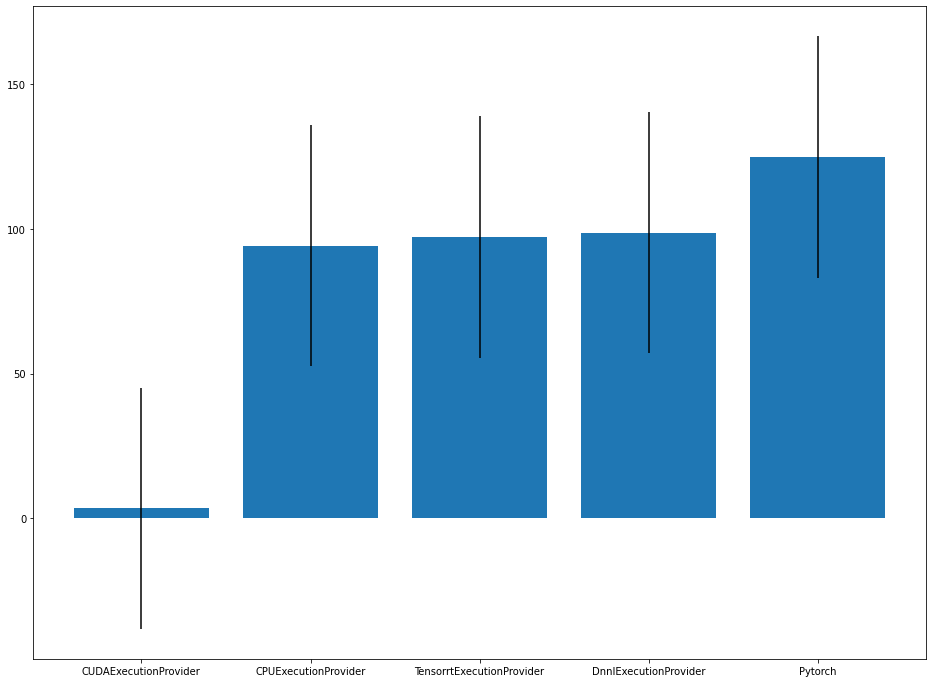

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Compute average inference time + std
time_results = {k: np.mean(v.model_inference_time) * 1e3 for k, v in results.items()}
time_results_std = np.std([v.model_inference_time for v in results.values()]) * 1000

plt.figure(figsize=(16, 12))
plt.ylabel = "Avg Inference time (ms)" 
plt.title = "Average inference time (ms) for each provider"
plt.bar(time_results.keys(), time_results.values(), yerr=time_results_std)

plt.show()